In [1]:

from datetime import timedelta
import time
import numpy as np
from functools import partial
#from sklearn.model_selection import train_test_split
import itertools
import pickle
import pandas as pd

from functools import partial
import itertools

from multiprocessing import Pool

In [2]:
def getCol2Count(df,col):
    return dict(df[col].value_counts())
    
def __removeChatteringAlarmsHelper(alarms,chattering_timedelta_threshold, chattering_count_threshold):
        """Find the chatterings in an alarms list from the same source.  
        """

        alarms_without_chattering = []
        alarms = [alarm for alarm in sorted(alarms, key=lambda arg: arg["StartTime"], reverse=False)]
        i = 0
        j = 0

        while i < (len(alarms)):
            alarms_without_chattering.append(alarms[i])
            prev_start = alarms[i]["StartTime"]
            prev_end = alarms[i]["EndTime"]
            count_alarms = 0
            j = i + 1
            while j < len(alarms):
                next_start = alarms[j]["StartTime"]
                next_end = alarms[j]["EndTime"]

                # this assert is very important: the prev alarm has to turn off before the start of
                # the next one
                assert(prev_start <= next_start)
                assert(prev_end <= next_start)
                assert(prev_end <= next_end)

                delta = timedelta.total_seconds(next_start - prev_start)
                assert (delta >= 0)
                
                if delta > chattering_timedelta_threshold:
                    break
                count_alarms += 1
                
                j += 1
            
            if count_alarms >= chattering_count_threshold:
                i = j
            else:
                i += 1

        return alarms_without_chattering
    
def tempFun(df,chat_delta,chat_count,sname):

    alarms_without_chatterings = []
    df_source = df.loc[df['SourceName'].isin([sname])]

    for condition in df_source["Condition"].unique():
        df_condition = df_source.loc[df_source['Condition'].isin([condition])]
        alarms = __removeChatteringAlarmsHelper(df_condition.to_dict(orient="records"),chattering_timedelta_threshold=chat_delta,chattering_count_threshold=chat_count)
        alarms_without_chatterings = alarms_without_chatterings + alarms
    
    return alarms_without_chatterings

def removeChatteringAlarms(df,chattering_timedelta_threshold=None,chat_count=None):

    # for sname in df["SourceName"].unique():

    alarms_without_chatterings = [] 
    sources=[sname for sname in df["SourceName"].unique()] 

    myFun =  partial(tempFun,df,chattering_timedelta_threshold,chat_count)
    

    with Pool(3) as p:
        alarms_without_chatterings = p.map(myFun, sources)

    alarms_without_chatterings = list(itertools.chain.from_iterable(alarms_without_chatterings))
    return pd.DataFrame(alarms_without_chatterings)



class AlarmsProcessing:
    def __init__(self,config) -> None:
        self.config = config
        self.alias2name = None
        self.name2alias = None
        self.df = pd.read_csv(self.config['file-path'], low_memory=False, usecols=self.config['usecols'],parse_dates=self.config['date-cols'])
        if self.config['alias']:
            self.convertSourceNamesToAlias()
        
        for m in self.df["Year-Month"].unique():
            
            month_df = self.df[self.df["Year-Month"].isin([m])].sort_values(by='StartTime', ascending=True).reset_index(drop=True)

            days = sorted(list(month_df['Day'].unique()))
            print(f"[{m}],Days:{days}")
    
    def convertSourceNamesToAlias(self):
        alias2name = {f"A{k}": v for k, v in enumerate(self.df["SourceName"].unique())}
        name2alias = {v: k for k, v in alias2name.items()}
        self.df["SourceName"] = self.df["SourceName"].apply(lambda sname: name2alias[sname])
        self.alias2name = alias2name
        self.name2alias = name2alias
        # return name2alias, alias2name

    def removeChatteringAlarms(self,df,chattering_timedelta_threshold=60,chattering_count_threshold=2):
        return removeChatteringAlarms(df=df,chattering_timedelta_threshold=chattering_timedelta_threshold,chat_count=chattering_count_threshold)

    def removeMomentaryAlarms(self,df,monmentarly_filter=None):
        df = df[(df["TimeDelta"] > monmentarly_filter)].reset_index(drop=True)
        return df

    def removeStalingAlarms(self,df,staling_filter=None):
        df =  df[(df["TimeDelta"] < staling_filter)].reset_index(drop=True)
        return df

    def removeConditionsAlarms(self,df,conditions_filter):
        df = df[~df["Condition"].isin(conditions_filter)].reset_index(drop=True)
        return df

    def removeSources(self,df, sources_filter):
        df = df[(~df["SourceName"].isin(sources_filter))].reset_index(drop=True)
        return df
    
    def removeSourcesBasedOnMinCount(self,df,min_alarms_per_source_filter):
        source2count = dict(df["SourceName"].value_counts())
        select_sources = [k for k, v in source2count.items() if v >= min_alarms_per_source_filter]
        df = df[df["SourceName"].isin(select_sources)]
        return df

    def getDFWithCommonSourcesInAllMonths(self,df):
        each_month_source_names = [[sname for sname in df[df["Year-Month"]==month]["SourceName"].unique()] for month in df["Year-Month"].unique()]
        common_sourcenames_in_all_months = set.intersection(*[set(l) for l in each_month_source_names])
        df = df[df["SourceName"].isin(common_sourcenames_in_all_months)]
        return df
      
    def updatSourceNamewithCondition(self,df):
        def _concatenateSourceNameAndCondition(sname, condition):
            return sname+"-"+condition
        df["SourceName"] = df[["SourceName", "Condition"]].apply(
            lambda arg: _concatenateSourceNameAndCondition(*arg), axis=1)
        return df
    
    def getCondition2Sources(self,df,condition):
        return df[df["Condition"]==condition]["SourceName"].unique()


In [16]:
class PrepareDataset:
    def __init__(self,config) -> None:
        self.config = config

    def getSeqsFromAlarmsDF(self,df,seq_duration_gap,filter_short_seq):
        """This function converts alarm dataframe into sequences of alarms.

        Args:
            df (_type_): Alarm dataset
            seq_duration_gap (_type_): The duration gap that will define the sequences. If it excesses this limit, upcoming alarms will be added in another sequence
            filter_short_seq (_type_): The minimum length of sequences. 

        Returns:
            _type_: list of sequences of alarms.
        """
        print(f">> Duration to next seq: {seq_duration_gap}, ignore seq len: {filter_short_seq}")

        list_of_sequences = []    
        alarms= df.sort_values(by='StartTime', ascending=True).reset_index(drop=True).to_dict(orient="records")  # records’ : list like [{column -> value}, … , {column -> value}]
        
        alarms = [alarm for alarm in sorted(alarms, key=lambda arg: arg["StartTime"], reverse=False)] # sorting

        # print('check',len(alarms))
        assert alarms[0]['StartTime'] < alarms[-1]['StartTime']
        i =0
        j= 0

        max_seq_len = -1
        while i <len(alarms):
            prev_start = alarms[i]["StartTime"]
            seq = []
            seq.append(alarms[i])
            j = i+1
            while j < len(alarms):    
                next_start = alarms[j]["StartTime"]
                delta = timedelta.total_seconds(next_start - prev_start)
                # print(delta)
                assert delta >= 0
                if delta >= seq_duration_gap:
                    break

                seq.append(alarms[j])
                j += 1
            i = j

            if len(seq) > max_seq_len:
                max_seq_len = len(seq)
            
            if len(seq)>=filter_short_seq:
                seq = [alarm for alarm in sorted(seq, key=lambda arg: arg["StartTime"], reverse=False)]
                seq = [alarm["SourceName"] for alarm in seq]
                list_of_sequences.append(seq)
        
        
        return list_of_sequences, max_seq_len


    def splitDFtoTrainValidDfsPerMonthByRows(self,df,p=0.2):    
        tarain_dfs = []
        valid_dfs = []
        for m in df["Year-Month"].unique():
            
            month_df = df[(df["Year-Month"].isin([m]))].sort_values(by='StartTime', ascending=True).reset_index(drop=True)

            train_df = month_df[0:int(len(month_df)*(1-p))]
            train_df = train_df.reset_index(drop=True)
            valid_df = month_df[int(len(month_df)*(1-p)):]
            valid_df = valid_df.reset_index(drop=True)
            assert len(train_df)+len(valid_df) == len(month_df)
            tarain_dfs.append(train_df)
            valid_dfs.append(valid_df)
        
        t_df = pd.concat(tarain_dfs, ignore_index=True).sort_values(by='StartTime', ascending=True).reset_index(drop=True)
        v_df = pd.concat(valid_dfs, ignore_index=True).sort_values(by='StartTime', ascending=True).reset_index(drop=True)

        assert len(t_df)+len(v_df) == len(df) 

        return t_df, v_df
    
    def splitDFtoTrainValidDfsPerMonthByDays(self,df,p=0.2):    
        tarain_dfs = []
        valid_dfs = []
        for m in df["Year-Month"].unique():
            
            month_df = df[(df["Year-Month"].isin([m]))].sort_values(by='StartTime', ascending=True).reset_index(drop=True)

            days = sorted(list(month_df['Day'].unique()))
            # if len(days)<5:
            #     print(f"Skipping : [{m}],Days:{days}")
            #     continue
            
            print(f"[{m}]: Days: {days}")

            train_days = days[0:len(days)-int(len(days)*p)]
            valid_days = days[len(days)-int(len(days)*p):len(days)]
            # print(f"[{m}]Train Days: {train_days}, val days = {valid_days} ")

            train_df = month_df[month_df['Day'].isin(train_days)].reset_index(drop=True)
            valid_df = month_df[month_df['Day'].isin(valid_days)].reset_index(drop=True)

            assert len(train_df)+len(valid_df) == len(month_df)
            tarain_dfs.append(train_df)
            valid_dfs.append(valid_df)
        
        t_df = pd.concat(tarain_dfs, ignore_index=True).sort_values(by='StartTime', ascending=True).reset_index(drop=True)
        v_df = pd.concat(valid_dfs, ignore_index=True).sort_values(by='StartTime', ascending=True).reset_index(drop=True)

        # assert len(t_df)+len(v_df) == len(df) 

        return t_df, v_df
    
    def writeSequeces2TokenFile(self,file_path,li_of_seqs):
        with open(file_path,"w") as f:
            for seq in li_of_seqs:
                f.write(f"{' '.join(seq)}\n")
        
        print("Done")

In [4]:
config = {
    'file-path': "/Users/hamzagorgulu/Desktop/thesis/Waris Final/tupras/data/final-all-months-alarms-with-day-filtered.csv",
    'usecols':["SourceName", "Condition", "StartTime","EndTime","TimeDelta","Year-Month",'Day'],
    'date-cols':   ["StartTime", "EndTime"],
    'alias': False
}

alarm = AlarmsProcessing(config=config)

start = time.time()

print("Total Time to load the data ", time.time()-start)

alarm.df

[(2020, 3)],Days:[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22]
[(2019, 7)],Days:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[(2019, 8)],Days:[1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31]
[(2019, 3)],Days:[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[(2019, 10)],Days:[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[(2019, 11)],Days:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 24, 25, 26, 27, 28, 29, 30]
[(2019, 9)],Days:[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 30]
[(2020, 2)],Days:[1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29]
[(2019, 5)],Days:[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30,

,SourceName,Condition,StartTime,EndTime,TimeDelta,Year-Month,Day
0,48TIC2026,VEL-,2020-03-01 00:00:03,2020-03-01 00:00:05,2.0,"(2020, 3)",1
1,48TIC2026,VEL-,2020-03-01 00:00:07,2020-03-01 00:00:08,1.0,"(2020, 3)",1
2,48TIC2026,VEL-,2020-03-01 00:00:10,2020-03-01 00:00:11,1.0,"(2020, 3)",1
3,48TIC2026,VEL-,2020-03-01 00:00:18,2020-03-01 00:00:20,2.0,"(2020, 3)",1
4,48TIC2026,VEL-,2020-03-01 00:00:22,2020-03-01 00:00:23,1.0,"(2020, 3)",1
...,...,...,...,...,...,...,...
12222295,47TIC1514,LO,2020-01-09 02:54:38,2020-01-09 03:05:56,678.0,"(2020, 1)",9
12222296,47PI055,LL,2020-01-09 02:53:46,2020-01-09 03:23:32,1786.0,"(2020, 1)",9
12222297,47FI1503C,LLL,2020-01-23 14:02:23,2020-01-23 14:02:24,1.0,"(2020, 1)",23
12222298,47PI1517B,LLL,2020-01-09 02:54:19,2020-01-09 02:58:34,255.0,"(2020, 1)",9


In [5]:
con2count=getCol2Count(df=alarm.df,col='Condition')
con2count

#Important  Trip, HHH, HTRP, LTRP, LLL, -> most imp

{'VEL+': 3784276,
 'IOP': 3660184,
 'VEL-': 3386264,
 'ALM': 439927,
 'IOP-': 236727,
 'LLL': 177912,
 'LTRP': 170050,
 'CNF': 168540,
 'LL': 59779,
 'LO': 47511,
 'HI': 30722,
 'HHH': 24753,
 'HTRP': 14119,
 'ANS-': 12705,
 'HH': 4559,
 'DV-': 2424,
 'DV+': 1066,
 'MLO': 645,
 'ANS+': 54,
 'MHI': 53,
 'OOP': 28,
 'CERR': 1,
 'TRIP': 1}

In [6]:
# remove communication alarms
df = alarm.removeConditionsAlarms(df=alarm.df,conditions_filter=["IOP", "IOP-",'VEL-','VEL+'])
con2count=getCol2Count(df=df,col='Condition')
con2count

{'ALM': 439927,
 'LLL': 177912,
 'LTRP': 170050,
 'CNF': 168540,
 'LL': 59779,
 'LO': 47511,
 'HI': 30722,
 'HHH': 24753,
 'HTRP': 14119,
 'ANS-': 12705,
 'HH': 4559,
 'DV-': 2424,
 'DV+': 1066,
 'MLO': 645,
 'ANS+': 54,
 'MHI': 53,
 'OOP': 28,
 'CERR': 1,
 'TRIP': 1}

In [11]:
"""
df = alarm.removeChatteringAlarms(df=df,chattering_timedelta_threshold=60,chattering_count_threshold=3)
con2count=getCol2Count(df=df,col='Condition')
con2count
""" 

"\ndf = alarm.removeChatteringAlarms(df=df,chattering_timedelta_threshold=60,chattering_count_threshold=3)\ncon2count=getCol2Count(df=df,col='Condition')\ncon2count\n"

In [8]:
# df3 = alarm.removeConditionsAlarms(df=alarm.df,conditions_filter=["IOP", "IOP-",'VEL+','VEL-'])
# con2count=getCol2Count(df=df3,col='Condition')
# print(con2count)
# df4 = removeChatteringAlarms(df=df3,chattering_timedelta_threshold=60, chat_count =2)
# con2count=getCol2Count(df=df4,col='Condition')
# con2count

In [9]:
# total = 0
# for cond,count in getCol2Count(df=df,col='Condition').items(): 
#     l = df[df['Condition']==cond]["SourceName"].unique()
#     total += len(l)

#     print(f">>{cond},{count},{len(l)}")


# print(len(getCol2Count(df,col='SourceName')),total)



In [7]:
df2 = alarm.removeSourcesBasedOnMinCount(df,min_alarms_per_source_filter=70)
total = 0
for cond,count in getCol2Count(df=df2,col='Condition').items(): 
    l = df2[df2['Condition']==cond]["SourceName"].unique()
    total += len(l)

    print(f">>{cond},{count},{len(l)}")


print(len(getCol2Count(df2,col='SourceName')),total)


>>ALM,437466,45
>>LLL,177271,31
>>LTRP,169602,27
>>CNF,168375,9
>>LL,59263,78
>>LO,46023,100
>>HI,29502,106
>>HHH,24448,11
>>HTRP,14021,10
>>ANS-,12700,2
>>HH,4256,69
>>DV-,2336,26
>>DV+,988,23
>>MLO,632,1
>>ANS+,54,1
>>MHI,51,2
>>OOP,6,1
218 542


In [11]:
# temp_sources = []

# for s in df["SourceName"].unique():
#     # print(len(df2[df2['SourceName']==s]['Condition'].unique()))
#     if len(df[df['SourceName']==s]['Condition'].unique())==1:
#         temp_sources.append(s)


# print(temp_sources)


In [9]:

FINAL_DF = df2

alarm_dataset = PrepareDataset({})
train_df, valid_df = alarm_dataset.splitDFtoTrainValidDfsPerMonthByDays(FINAL_DF,p=0.3)
valid_df, test_df = alarm_dataset.splitDFtoTrainValidDfsPerMonthByDays(valid_df,p=0.2)

[(2020, 3)]: Days: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22]
[(2019, 7)]: Days: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[(2019, 8)]: Days: [1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31]
[(2019, 3)]: Days: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[(2019, 10)]: Days: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[(2019, 11)]: Days: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 24, 25, 26, 27, 28, 29, 30]
[(2019, 9)]: Days: [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 30]
[(2020, 2)]: Days: [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29]
[(2019, 6)]: Days: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25

In [15]:
seqs_train, _  = alarm_dataset.getSeqsFromAlarmsDF(train_df,seq_duration_gap=60*15,filter_short_seq=0)
seqs_valid, _  = alarm_dataset.getSeqsFromAlarmsDF(valid_df,seq_duration_gap=60*15,filter_short_seq=0)
seqs_test, _  = alarm_dataset.getSeqsFromAlarmsDF(test_df,seq_duration_gap=60*15,filter_short_seq=0)

>> Duration to next seq: 900, ignore seq len: 0
>> Duration to next seq: 900, ignore seq len: 0
>> Duration to next seq: 900, ignore seq len: 0


In [14]:
print(len(seqs_train), len(seqs_valid), len(seqs_test))

19919 6581 1029


In [19]:
# now lets implement the gloVe word embedding.
import import_ipynb
from gloVe_helpers import *

importing Jupyter notebook from gloVe_helpers.ipynb


[nltk_data] Downloading package reuters to
[nltk_data]     /Users/hamzagorgulu/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [37]:
distint_train_alarms, num_train_alarm_sources = distinct_words(seqs_train)
alarms = distint_train_alarms[40:45]

In [25]:
M, word2ind = compute_co_occurrence_matrix(seqs_train, window_size=4)
M_reduced = reduce_to_k_dim(M)
print(M_reduced[0])

Running Truncated SVD over 218 words...
Done.
[5285.66182423 3973.03485826]


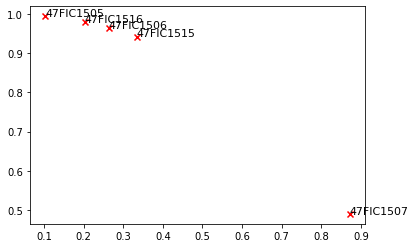

In [38]:
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting


alarms = alarms
plot_embeddings(M_normalized, word2ind, alarms)

In [ ]:
alarm_dataset.writeSequeces2TokenFile(file_path="../.data/train.tokens",li_of_seqs=seqs_train)
alarm_dataset.writeSequeces2TokenFile(file_path="../.data/val.tokens",li_of_seqs=seqs_valid)
alarm_dataset.writeSequeces2TokenFile(file_path="../.data/test.tokens",li_of_seqs=seqs_test)

print("DataSet is complete")

In [13]:
# duration_from_1_seq_to_next = 60*15 # duration in seconds
# filter_short_seq = 3 # remove the sequence whose size is less than 4
# li_of_seqs,max_seq_len = getSequenceOfWholeData(df_rnn,duration_from_1_seq_to_next,filter_short_seq)
# print(len(li_of_seqs))
# print(li_of_seqs[:2])

In [14]:
# seq_len_2_count ={}
# for seq in li_of_seqs:
#     # seq = removeSameAlarms(seq)
#     l = len(seq)
#     seq_len_2_count[l] = 1+seq_len_2_count.get(l,0)

# seq_len_2_count = {k:v for k,v in sorted(seq_len_2_count.items(), key=lambda t: t[1] )}
# seq_len_2_count

In [15]:
# def removeSameAlarms(seq):
#     new_seq = []

#     new_seq.append(seq[0])

#     for a in seq:

#         if a == new_seq[-1]:
#             continue
#         new_seq.append(a)
    
#     return new_seq





In [16]:
# sum(seq_len_2_count.keys())/len(seq_len_2_count.keys())
# l = 5*['5']